# Lab Image Processing Class - Image Classification with Keras/Tensorflow

Today we will classify vegetables from images. The dataset we will use is from a publication about transfer learning to boost image classification (M. Israk Ahmed et al, ICCCSP 2021) and the full dataset is available on [Kaggle](https://www.kaggle.com/datasets/misrakahmed/vegetable-image-dataset?select=Vegetable+Images). I reduced the dataset size so that the training time and RAM usage is reduced.

This Google colab written with the input of a few great resources, such as:
- https://keras.io/examples/vision/image_classification_from_scratch/
- https://www.analyticsvidhya.com/blog/2020/10/create-image-classification-model-python-keras/


First off we would want to connect to a GPU accelerated runtime so that the training is fast and efficient. To do that, select Runtime > Change Runtime type > Hardware Accelerator > GPU. Using this runtime for longer periods of time exceeds the free use of Google Colabs, but for our labs it should be fine.

Then we will connect to our google drive via google colab. Then we will unzip the data and the models that I have pretrained just in case.



In [1]:
# connect to google drive
from google.colab import drive
drive.mount('/content/drive')#, force_remount = True)

Mounted at /content/drive


In [5]:
# Create folder to store the zipped data and copy the data from the google drive
# to our cloud computing space
!mkdir zipped_data/
# this path you have to change so that it points to the location you saved the data file to
!cp /content/drive/MyDrive/image_class/DL_image_class.zip zipped_data/

mkdir: cannot create directory ‘zipped_data/’: File exists


In [3]:
# Unzip the data folder
!unzip /content/zipped_data/DL_image_class.zip

Archive:  /content/zipped_data/DL_image_class.zip
   creating: DL_image_class/
  inflating: DL_image_class/.DS_Store  
 extracting: DL_image_class/subset_veg.zip  
   creating: DL_image_class/trained_models/
   creating: DL_image_class/trained_models/veg_50epoch/
 extracting: DL_image_class/trained_models/veg_50epoch/fingerprint.pb  
  inflating: DL_image_class/trained_models/veg_50epoch/keras_metadata.pb  
   creating: DL_image_class/trained_models/veg_50epoch/variables/
  inflating: DL_image_class/trained_models/veg_50epoch/variables/variables.data-00000-of-00001  
  inflating: DL_image_class/trained_models/veg_50epoch/variables/variables.index  
  inflating: DL_image_class/trained_models/veg_50epoch/saved_model.pb  
   creating: DL_image_class/trained_models/veg_50epoch/assets/
   creating: DL_image_class/trained_models/veg_transfer_50epoch/
 extracting: DL_image_class/trained_models/veg_transfer_50epoch/fingerprint.pb  
  inflating: DL_image_class/trained_models/veg_transfer_50epoc

In [4]:
# Unzip the images
!unzip /content/DL_image_class/subset_veg.zip

Archive:  /content/DL_image_class/subset_veg.zip
   creating: subset_veg/
   creating: subset_veg/test/
   creating: subset_veg/test/Capsicum/
  inflating: subset_veg/test/Capsicum/0012.jpg  
  inflating: subset_veg/test/Capsicum/0006.jpg  
  inflating: subset_veg/test/Capsicum/0007.jpg  
  inflating: subset_veg/test/Capsicum/0013.jpg  
  inflating: subset_veg/test/Capsicum/0005.jpg  
  inflating: subset_veg/test/Capsicum/0011.jpg  
  inflating: subset_veg/test/Capsicum/0010.jpg  
  inflating: subset_veg/test/Capsicum/0004.jpg  
  inflating: subset_veg/test/Capsicum/0028.jpg  
  inflating: subset_veg/test/Capsicum/0014.jpg  
  inflating: subset_veg/test/Capsicum/0015.jpg  
  inflating: subset_veg/test/Capsicum/0001.jpg  
  inflating: subset_veg/test/Capsicum/0029.jpg  
  inflating: subset_veg/test/Capsicum/0017.jpg  
  inflating: subset_veg/test/Capsicum/0003.jpg  
  inflating: subset_veg/test/Capsicum/0002.jpg  
  inflating: subset_veg/test/Capsicum/0016.jpg  
  inflating: subset_veg/

## Introduction

In [6]:
# Imports

# Miscellaneous operating system libraries
import os
import shutil
import numpy as np
import random

# Libraries for plotting
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from IPython.display import display, Image

# Deep learning libraries Keras and Tensorflow for training and sklearn for the metrics
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout 
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report,confusion_matrix
import tensorflow as tf

The dataset that we are using is simple, but you may also download images from other sources, such as [Open Images Dataset V6](https://storage.googleapis.com/openimages/web/index.html) or [Kaggle](https://www.kaggle.com/datasets), or even use your own data. In any case, make sure that your dataset is organized in the following way and that you point towards the right paths.

- Data
    - train
        - Class 1
        - Class 2
        - Class n
    - validation
        - Class 1
        - Class 2
        - Class n
    - test
        - Class 1
        - Class 2
        - Class n
    - model

## Data preparation

In the data preparation we will save the data in memory as numpy arrays, resize to the same dimensions and take a sneak peak into some of the images. Lastly, we can do data augmentation (or skip it for now).

In [9]:
# Data folder
data_folder = '/content/subset_veg/'

# Get the class names
classes = os.listdir(data_folder + 'train/')

# Function to load data into memory as numpy arrays
def get_data(data_dir, classes, img_size):
    data = [] 
    for label in classes: 
        path = os.path.join(data_dir, label)
        class_num = classes.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img))[...,::-1] #convert BGR to RGB format
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data, dtype=object)


In [10]:
# Define the target image size, the larger, the more features, but also longer training times.
img_size = 224

# load training and validation into memory as
train = get_data(data_folder + 'train/', classes, img_size)
val = get_data(data_folder + 'validation/', classes, img_size)
test = get_data(data_folder + 'test/', classes, img_size)

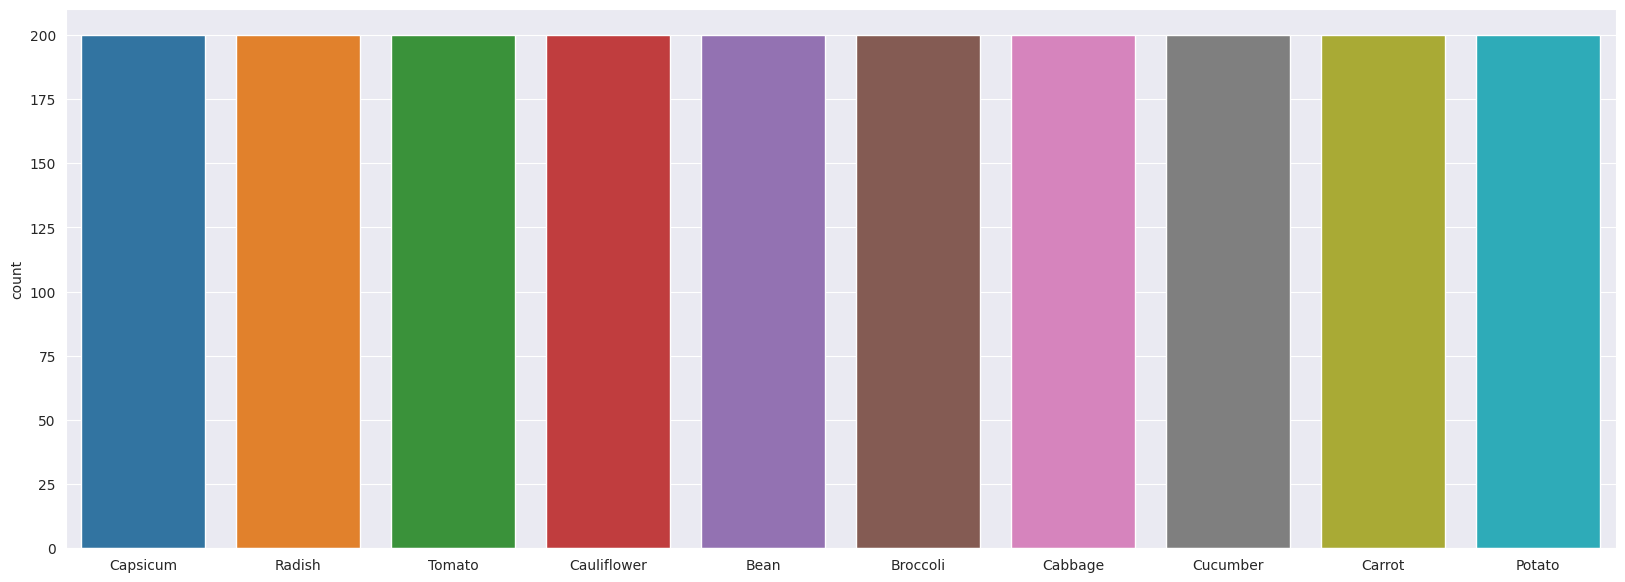

In [12]:
# Review how many of the training images are availabe
# Useful to verify that we loaded all the images from the training data set as numpy arrays
# Sometimes, with faulty file endings, there might be errors

l = []
for i in train:
  l.append(classes[i[1]])  
plt.figure(figsize = (20,7))
sns.set_style('darkgrid')
sns.countplot(x=l)
plt.show()

# Best case scenario we have 200 training images for 10 classes

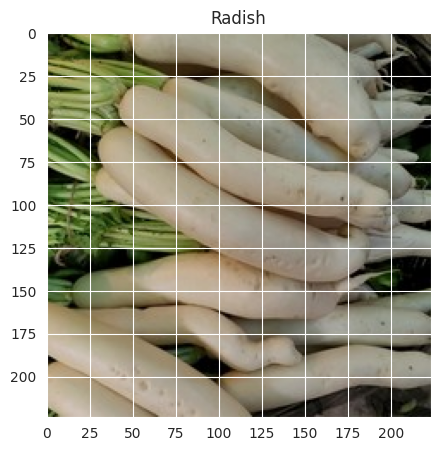

In [14]:
# Show a random image from any class from the training data set

plt.figure(figsize = (5,5))
n = random.choice(train)
plt.imshow(n[0])
plt.title(classes[n[1]])
plt.show()

In [15]:
# Data preprocessing
x_train = []
y_train = []
x_val = []
y_val = []
x_test = []
y_test = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)

for feature, label in val:
    x_val.append(feature)
    y_val.append(label)

for feature, label in test:
    x_test.append(feature)
    y_test.append(label)

# Normalize the data for better training of the model
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255
x_test = np.array(x_test) / 255

x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

x_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)

In [17]:
# If we want to we can try to use Data augmentation on the training data

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images

# For now we will skip it, but we can always uncomment the line below
#datagen.fit(x_train)

## Model Definition

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 112, 112, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 112, 112, 32)      9248      
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 56, 56, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 56, 56, 64)        18496     
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 28, 28, 64)      

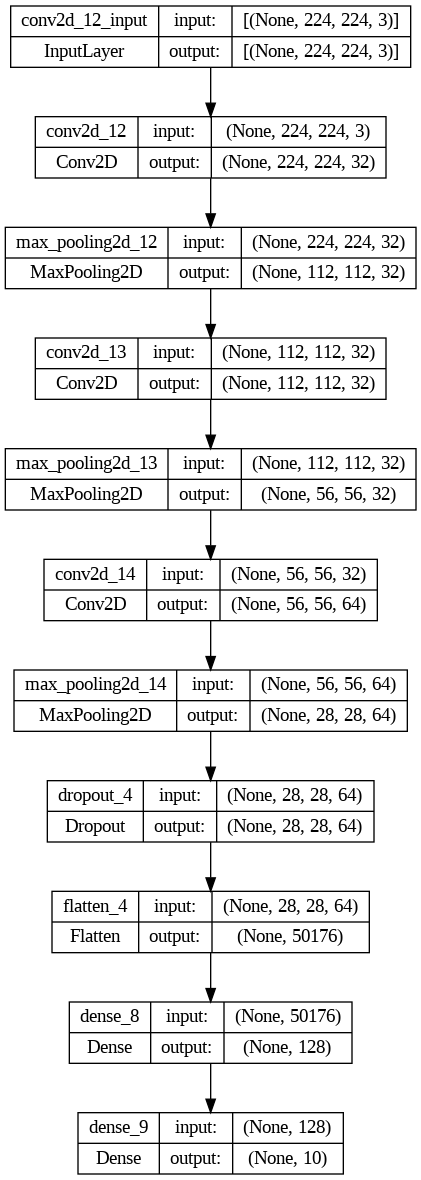

In [22]:
# Define the model 
# This is a simple CNN model with 3 Convolutional layers that are then followed by max-pooling layer.
# Finally, a dropout layer is added to avoid overfitting (it might still happen).

# We initiate a model here (more information on https://keras.io/api/models/sequential/)
# and then we add more layers to the model
# Documentation on each layer, activation function etc. can be found here https://keras.io/api/layers/
model = Sequential()
model.add(Conv2D(32,3,padding="same", activation="relu", input_shape=(img_size,img_size,3)))
model.add(MaxPool2D())

model.add(Conv2D(32, 3, padding="same", activation="relu"))
model.add(MaxPool2D())

model.add(Conv2D(64, 3, padding="same", activation="relu"))
model.add(MaxPool2D())
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(128,activation="relu"))

# the last layer has as many outputs as there are classes
model.add(Dense(len(classes), activation="softmax"))

# A summary of the model is going to be printed below
model.summary()

# A summary of the model is going to be printed below
keras.utils.plot_model(model, show_shapes=True)

## Training

Now we define what kind of optimizer we use for the training process. There are many different optimizers that you could choose from and you can find them here (https://keras.io/api/optimizers/). For now, I will choose the Adam optimizer. It is a stochastic gradient descent method based on adaptive estimation of first-order and second-order moments (From https://keras.io/api/optimizers/adam/).

We will also have to set the learning rate (float from 0.0 - 1.0) for our stochastic gradient descent. The learning rate can be defined as the amount that the weights are updated during training per epoch. It controls how quickly the model tries to adapt to the problem. With larger learning rates the model might learn too quickly and unstable, while with smaller learning rates the model needs more epochs to finish training successfully (more info here https://machinelearningmastery.com/understand-the-dynamics-of-learning-rate-on-deep-learning-neural-networks/).

Apart from the size of the data set, the learning rate and the number of epochs might be the two most important parameters for using deep learning algorithms.

In [23]:
# Set learning rate and epochs
lr_training = 0.0001
epochs = 50

# Set the optimizer and compile model
# The Adam optimization is a stochastic gradient descent method, more information
# https://keras.io/api/optimizers/adam/
opt = Adam(lr_training)


# Set the loss calculation, here we will use Sparse Categorical Crossentropy 
# (https://www.tensorflow.org/api_docs/python/tf/keras/losses/SparseCategoricalCrossentropy)
model.compile(
    optimizer = opt , loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
    metrics = ['accuracy']
            )

In [24]:
# Check that CPU and/or GPU is used
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 6176811629654830664
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 40146370560
locality {
  bus_id: 1
  links {
  }
}
incarnation: 9414643883363907481
physical_device_desc: "device: 0, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:00:04.0, compute capability: 8.0"
xla_global_id: 416903419
]


In [25]:
# Start the training
# This step might take a while depending on the size of the data set, 
# the number of epochs and your computational power
history = model.fit(x_train,y_train,epochs = epochs , validation_data = (x_val, y_val))

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


63/63 [==============================] - 13s 28ms/step - loss: 2.0240 - accuracy: 0.2845 - val_loss: 1.6148 - val_accuracy: 0.4233
Epoch 2/50
63/63 [==============================] - 1s 14ms/step - loss: 1.3830 - accuracy: 0.5220 - val_loss: 1.1064 - val_accuracy: 0.5900
Epoch 3/50
63/63 [==============================] - 1s 14ms/step - loss: 0.9491 - accuracy: 0.6720 - val_loss: 0.8799 - val_accuracy: 0.7000
Epoch 4/50
63/63 [==============================] - 1s 14ms/step - loss: 0.6946 - accuracy: 0.7665 - val_loss: 0.7937 - val_accuracy: 0.7067
Epoch 5/50
63/63 [==============================] - 1s 15ms/step - loss: 0.5674 - accuracy: 0.8110 - val_loss: 0.6039 - val_accuracy: 0.7933
Epoch 6/50
63/63 [==============================] - 1s 14ms/step - loss: 0.4438 - accuracy: 0.8495 - val_loss: 0.5191 - val_accuracy: 0.8267
Epoch 7/50
63/63 [==============================] - 1s 14ms/step - loss: 0.3391 - accuracy: 0.9050 - val_loss: 0.5757 - val_accuracy: 0.7967
Epoch 8/50
63/63 [=====

Now, the model has finished training and can be evaluated. If there was some errors during training, you can load a pretrained model below. They can be found in the DL_image_class folder. There is a model that has been trained from scratch and a transfer learning model.

If your model trained without major errors, you can keep the code below commented.

In [29]:
# Load model
#model_path = '/content/DL_image_class/trained_models/veg_50epoch/'
#model = keras.models.load_model(model_path)

### Explanation of training metrices

- Loss: Measures the difference between raw prediction (float) and class (0, 1)
- Accuracy: Measures the difference between thresholded prediction (0, 1) and class (0, 1)

Here, we differentiate between train loss/accuracy and val loss/accuracy. Both are calculated very similarly, but only the train loss/accuracy is taken into account when training the model, while the val loss/accuracy is only there for us to observe and is not participating in changing any parameters in the model.

Below we plot the accuracy and the loss.

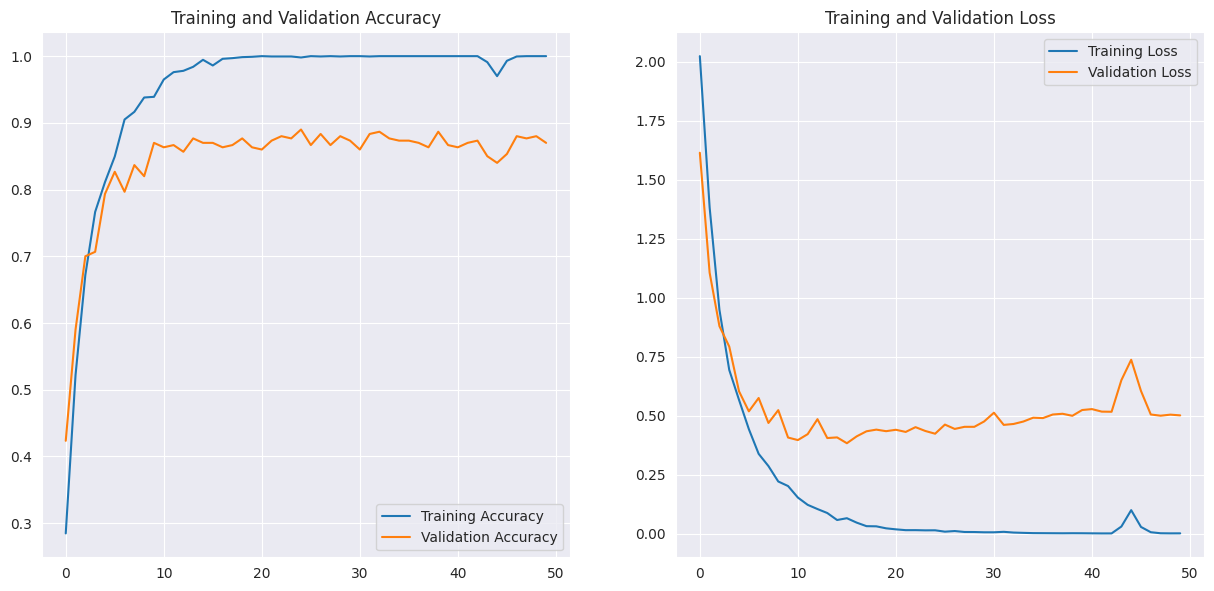

In [30]:
# Access all the variables from the history variable
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Epochs as variable
epochs_range = range(epochs)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

If you want to review good/bad learning curves with over/underfitting, you can do this here (https://machinelearningmastery.com/learning-curves-for-diagnosing-machine-learning-model-performance/).

Sometimes, it is not perfectly clear, whether under/overfitting is actually really bad for the problem we want to solve. Intuitively, we would think, that the validation loss and the validation accuracy are inversely correlated, but sometimes this is not the case. In a case where images with borderline predictions are getting predicted better and their output class changes (an image is classified with a score from 0.4 to 0.6) the loss decreases, while the accuracy increases. However, in a case where an image with a bad prediction score changes from 0.2 to 0.1, the loss decreases further, while the accuracy actually stays the same.

In a perfect world, the loss will decrease and the accuracy increase. If both increase, we can say that the network will start to overfit and both cases will happen at the same time. This means that features are learned that are good for the training data set and not so great for generalization/the validation data set. This will then lead to case 2. However, at the same time the network is still learning useful patterns leading to case 1. 

Long story short, overfitting may be considered bad, but whether we should stop training if the network learns bad patterns even though it is continuing to learn good patterns is difficult to answer.

If you observe, that your loss/accuracy curves look worse, consider changing your dataset size, epochs or learning rate.

Below, we will calculate the F1-score, the precision and the recall. Information on how exactly these scores are calculated and what they mean can be found here (https://towardsdatascience.com/metrics-to-evaluate-your-machine-learning-algorithm-f10ba6e38234).

In [31]:
# Get F1-score by predicting the test data set
predictions = np.argmax(model.predict(x_test), axis=-1)
predictions = predictions.reshape(1,-1)[0]
target_names = [classes[i] + ' (Class ' + str(i) + ')' for i in range(len(classes))]

print(classification_report(y_test, predictions, target_names = target_names))

10/10 [==============================] - 0s 7ms/step
                       precision    recall  f1-score   support

   Capsicum (Class 0)       1.00      1.00      1.00        30
     Radish (Class 1)       0.85      0.97      0.91        30
     Tomato (Class 2)       0.88      0.93      0.90        30
Cauliflower (Class 3)       0.93      0.93      0.93        30
       Bean (Class 4)       0.66      0.77      0.71        30
   Broccoli (Class 5)       0.92      0.77      0.84        30
    Cabbage (Class 6)       1.00      0.87      0.93        30
   Cucumber (Class 7)       0.81      0.73      0.77        30
     Carrot (Class 8)       1.00      1.00      1.00        30
     Potato (Class 9)       0.90      0.93      0.92        30

             accuracy                           0.89       300
            macro avg       0.90      0.89      0.89       300
         weighted avg       0.90      0.89      0.89       300



## Testing our model with random images

Next, we will use the trained model to make a prediction based on what it has learned from the data on images from the test data set.

1/1 [==============================] - 0s 21ms/step
Model predicted: Bean, Ground truth is Cucumber


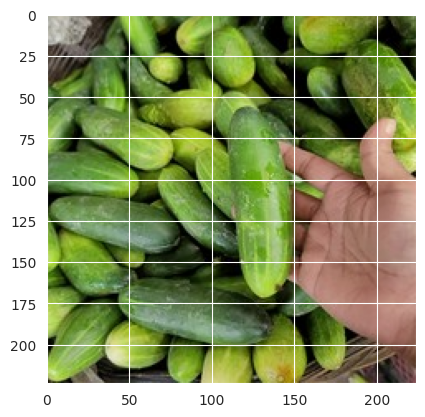

In [39]:
# select random image from test data set
rdm_img_id = random.choice([i for i in range(len(x_test[0]))])
img = x_test[rdm_img_id]
ground_truth_class = y_test[rdm_img_id]
prediction = model.predict(tf.expand_dims(img, 0))

pred_clas = prediction[0].tolist().index(max(prediction[0]))
print('Model predicted: ' + classes[pred_clas] + ', Ground truth is ' + classes[ground_truth_class])

plt.imshow(img)
plt.grid(None)
plt.show()

In [40]:
# If you are happy with your model you can save it
!mkdir /content/model/
model_save_path = '/content/model/veg_50epoch'
model.save(model_save_path)

In [41]:
# It is also possible to copy the trained model back to your google drive
!cp -r /content/model/ /content/drive/MyDrive/image_class/

# Transfer learning

In some cases, it is possible to improve the models performance using transfer learning, especially if the model was trained on a small dataset. To do that, we use an already trained network, freeze certain lower layers (base model) and re-train the upper layers with our data. We might get an increase in performance without having to increase the size of our dataset.

We will be creating the base model based on the [MobileNetV2](https://arxiv.org/abs/1801.04381) model. It was trained on the [ImageNet](https://www.image-net.org/) dataset with millions of images and thousands of classes.

In [42]:
# Load the base model
base_model = tf.keras.applications.MobileNetV2(input_shape = (img_size, img_size, 3), include_top = False, weights = "imagenet")
# Freeze base model
base_model.trainable = False

9406464/9406464 [==============================] - 1s 0us/step


In [43]:
# Initiate the transfer learning model
transfer_model = tf.keras.Sequential([base_model,
                                 tf.keras.layers.GlobalAveragePooling2D(),
                                 tf.keras.layers.Dropout(0.2),
                                 tf.keras.layers.Dense(len(classes), activation="softmax")                                     
                                ])


In [44]:
# Set learning rate and epochs
lr_transfer = 0.0001
epochs = 50
transfer_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_transfer),
               loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train
history = transfer_model.fit(x_train,y_train,epochs = epochs , validation_data = (x_val, y_val))

Epoch 1/50
63/63 [==============================] - 5s 33ms/step - loss: 2.3410 - accuracy: 0.2005 - val_loss: 1.8038 - val_accuracy: 0.4067
Epoch 2/50
63/63 [==============================] - 1s 16ms/step - loss: 1.5437 - accuracy: 0.5110 - val_loss: 1.1644 - val_accuracy: 0.7667
Epoch 3/50
63/63 [==============================] - 1s 16ms/step - loss: 1.0421 - accuracy: 0.7375 - val_loss: 0.7753 - val_accuracy: 0.8800
Epoch 4/50
63/63 [==============================] - 1s 16ms/step - loss: 0.7218 - accuracy: 0.8610 - val_loss: 0.5462 - val_accuracy: 0.9333
Epoch 5/50
63/63 [==============================] - 1s 16ms/step - loss: 0.5393 - accuracy: 0.9155 - val_loss: 0.4077 - val_accuracy: 0.9633
Epoch 6/50
63/63 [==============================] - 1s 16ms/step - loss: 0.4323 - accuracy: 0.9370 - val_loss: 0.3180 - val_accuracy: 0.9733
Epoch 7/50
63/63 [==============================] - 1s 16ms/step - loss: 0.3388 - accuracy: 0.9580 - val_loss: 0.2574 - val_accuracy: 0.9867
Epoch 8/50
63

### Visualization of training and validation curves of transfer learning

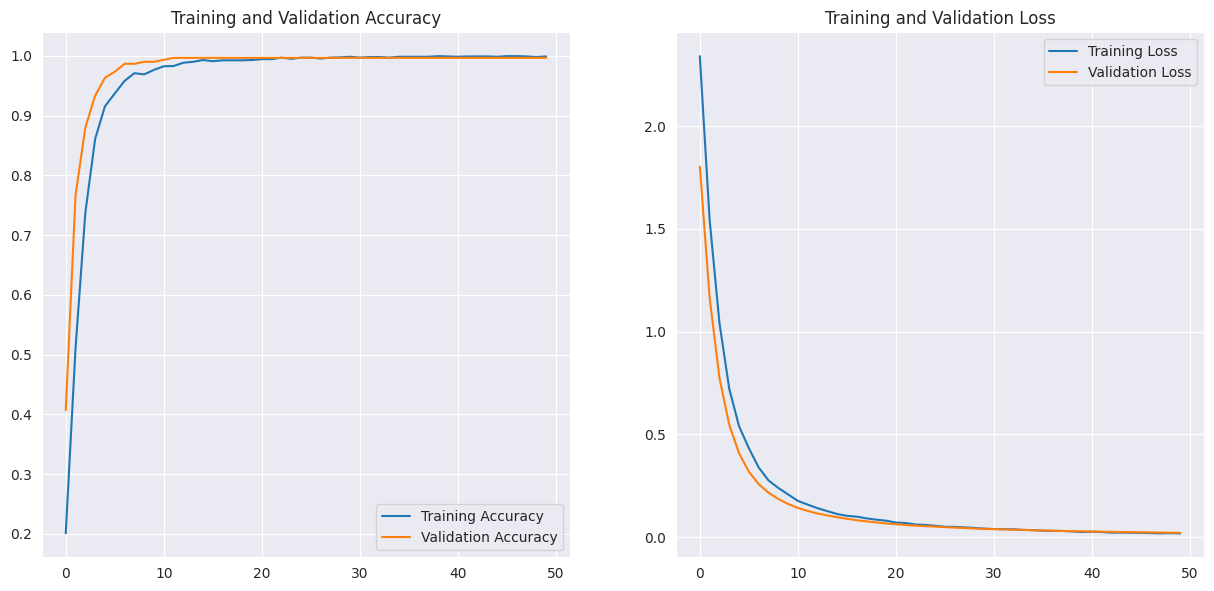

In [45]:
# Access all the variables from the history variable
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(epochs)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [46]:
# Get F1-score
predictions = np.argmax(transfer_model.predict(x_test), axis=-1)
predictions = predictions.reshape(1,-1)[0]
target_names = [classes[i] + ' (Class ' + str(i) + ')' for i in range(len(classes))]

print(classification_report(y_val, predictions, target_names = target_names))

10/10 [==============================] - 1s 12ms/step
                       precision    recall  f1-score   support

   Capsicum (Class 0)       1.00      1.00      1.00        30
     Radish (Class 1)       0.97      0.97      0.97        30
     Tomato (Class 2)       0.94      1.00      0.97        30
Cauliflower (Class 3)       1.00      1.00      1.00        30
       Bean (Class 4)       1.00      1.00      1.00        30
   Broccoli (Class 5)       1.00      0.97      0.98        30
    Cabbage (Class 6)       1.00      1.00      1.00        30
   Cucumber (Class 7)       1.00      1.00      1.00        30
     Carrot (Class 8)       1.00      1.00      1.00        30
     Potato (Class 9)       1.00      0.97      0.98        30

             accuracy                           0.99       300
            macro avg       0.99      0.99      0.99       300
         weighted avg       0.99      0.99      0.99       300



Based on the metrices, transfer learning improved the performance predicting on our dataset.

Lastly, we can classify random images and plot them.

1/1 [==============================] - 0s 26ms/step
Model predicted: Tomato, Ground truth is Tomato


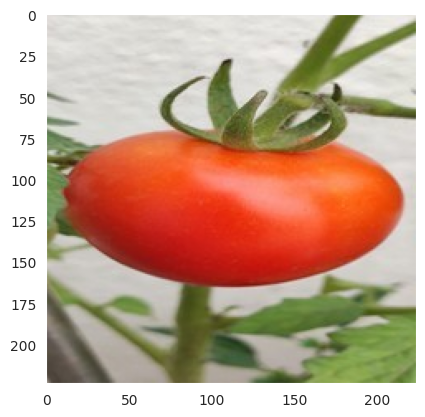

In [49]:
# select random image from test data set
rdm_img_id = random.choice([i for i in range(len(x_test[0]))])
img = x_test[rdm_img_id]
ground_truth_class = y_test[rdm_img_id]
prediction = transfer_model.predict(tf.expand_dims(img, 0))

pred_clas = prediction[0].tolist().index(max(prediction[0]))
print('Model predicted: ' + classes[pred_clas] + ', Ground truth is ' + classes[ground_truth_class])

plt.imshow(img)
plt.grid(None)
plt.show()


In [51]:
# If you are happy with your model you can save it
model_save_path = '/content/model/veg_transfer_50epoch'
model.save(model_save_path)

mkdir: cannot create directory ‘/content/model/’: File exists


In [125]:
# Copy models back to Google drive
!cp -r /content/model/ /content/drive/MyDrive/image_class/